Load Data

In [305]:
import pandas as pd

kode_saham = ["PBCRF","IBM","PHJMF","PTAIF","TLKMF"]#
#kode_saham = ["BA","INTC","AAPL","NVDA","IBM"]
n = len(kode_saham)
github = "https://raw.githubusercontent.com/relfarizi/Portfolio-Saham/master/Data/"
#data[0] = "https://raw.githubusercontent.com/relfarizi/Portfolio-Saham/master/"+data[0]+".csv"
#data[1] = "https://raw.githubusercontent.com/relfarizi/Portfolio-Saham/master/BKRKF.csv"
#data[2] = "https://raw.githubusercontent.com/relfarizi/Portfolio-Saham/master/PHJMF.csv"
#data[3] = "https://raw.githubusercontent.com/relfarizi/Portfolio-Saham/master/PTAIF.csv"
#data[4] = "https://raw.githubusercontent.com/relfarizi/Portfolio-Saham/master/TLKMF.csv"

df = []
for i in range(n) :
  datas = pd.read_csv(github+kode_saham[i]+".csv")
  data_tmp = datas["Close"]
  df.append(data_tmp)
  #print(data_tmp.shape)

dataset = pd.concat(df, axis=1, sort=False)
dataset.columns = kode_saham
dataset

,PBCRF,IBM,PHJMF,PTAIF,TLKMF
0,1.13,169.529999,0.31,0.593,0.27
1,1.13,167.339996,0.31,0.593,0.29
2,1.13,170.550003,0.31,0.593,0.28
3,1.05,177.300003,0.29,0.593,0.26
4,1.12,175.820007,0.29,0.593,0.28
...,...,...,...,...,...
100,1.70,119.339996,0.24,0.480,0.25
101,1.73,119.900002,0.25,0.480,0.27
102,1.70,110.940002,0.25,0.480,0.26
103,1.73,113.029999,0.25,0.480,0.26


In [265]:
dataset = dataset.dropna()
#print(type(dataset.corr()))
list_corr = []
for x in dataset.corr():
  list_corr.append(dataset.corr()[x].tolist())
  #print(dataset.corr()[x].tolist())
rho = np.array(list_corr)
print(rho)

[[ 1.         -0.56066585  0.17827889 -0.50894279 -0.38534622]
 [-0.56066585  1.          0.48841189  0.55194188  0.12149805]
 [ 0.17827889  0.48841189  1.          0.31961642 -0.0947149 ]
 [-0.50894279  0.55194188  0.31961642  1.          0.57773262]
 [-0.38534622  0.12149805 -0.0947149   0.57773262  1.        ]]


In [266]:
import statistics as st
var = []
for x in dataset :
  tmp = dataset[x].tolist()
  var.append(st.variance(tmp))
print(var)

[0.034232571228528755, 221.96610417552904, 0.0010388256161314412, 0.0034914524635922335, 0.0019262135922330098]


# Multi sekuritas


In [267]:
import numpy as np

std_dev = []
for i in var :
  std_dev.append(np.sqrt(i))
n = len(std_dev)

u = np.ones(n)
#print(u)
#rho = np.zeros((n,n))
#rho[0][1] = 0.1

#rho[0][2] = 0.2
#rho[0][3] = 0.2
#rho[0][4] = 0.2
#rho[1][2] = 0.2
#rho[1][3] = 0.2
#rho[1][4] = 0.2
#rho[2][3] = 0.2
#rho[2][4] = 0.2
#rho[3][4] = 0.2

for i in range(n) :
  for j in range(n) :
    if j == i :
      rho[i][j] = 1
    elif j < i :
      rho[i][j] = rho[j][i]
print(rho)

[[ 1.         -0.56066585  0.17827889 -0.50894279 -0.38534622]
 [-0.56066585  1.          0.48841189  0.55194188  0.12149805]
 [ 0.17827889  0.48841189  1.          0.31961642 -0.0947149 ]
 [-0.50894279  0.55194188  0.31961642  1.          0.57773262]
 [-0.38534622  0.12149805 -0.0947149   0.57773262  1.        ]]


In [268]:
print(rho[0][1])

-0.5606658474727311


In [0]:
def is_short_selling(rho,std_dev):
  n = len(rho)
  print(n)
  check = False
  #rho = rho.sort()
  std_Dev =std_dev.sort()

  for i in range(n):
    for j in range(n):
      if i < j :
        x = std_dev[i]/std_dev[j]
        #print(rho[i][j])
        if rho[i][j] > x :
          check =True
          break
  return check

In [270]:
print(rho)

[[ 1.         -0.56066585  0.17827889 -0.50894279 -0.38534622]
 [-0.56066585  1.          0.48841189  0.55194188  0.12149805]
 [ 0.17827889  0.48841189  1.          0.31961642 -0.0947149 ]
 [-0.50894279  0.55194188  0.31961642  1.          0.57773262]
 [-0.38534622  0.12149805 -0.0947149   0.57773262  1.        ]]


In [271]:
is_short_selling(rho,std_dev)

5


True

In [272]:
C = (np.zeros((n,n)))

for i in range(n):
  for j in range(n) :
    C[i][j] = std_dev[i]*rho[i][j]*std_dev[j]
print(C)

[[ 1.03882562e-03 -7.93099450e-04  3.39526996e-04 -3.03500946e-03
  -1.85040057e-01]
 [-7.93099450e-04  1.92621359e-03  1.26660593e-03  4.48193266e-03
   7.94446866e-02]
 [ 3.39526996e-04  1.26660593e-03  3.49145246e-03  3.49423340e-03
  -8.33805416e-02]
 [-3.03500946e-03  4.48193266e-03  3.49423340e-03  3.42325712e-02
   1.59253864e+00]
 [-1.85040057e-01  7.94446866e-02 -8.33805416e-02  1.59253864e+00
   2.21966104e+02]]


In [273]:
from numpy.linalg import inv
from numpy.linalg import det
u = np.ones(n)
uT = np.transpose(u)

CInv = inv(C)

w = np.dot(u,CInv)/(u.dot(CInv).dot(uT))
print(w)

[ 7.01980022e-01  4.75962932e-01 -1.92255130e-01  1.40695991e-02
  2.42576973e-04]


In [274]:
#w = np.array([0.3,0.4])
wT = np.transpose(w)
x = np.dot(u,wT)
print("jumlah w = ",x)

jumlah w =  1.0


In [275]:
risk = w.dot(C).dot(wT)
print(risk)

0.00019888525890988078


Expected return saham


In [0]:
import math
def find_ud(saham) :
  K = []
  
  
  for i in range(len(saham)-1) :
    x = (saham[i+1]-saham[i])/saham[i]
    K.append(x)
  up = []
  down = []

  for i in K :
    if i > 0 :
      x = 1
      y = 0
    else :
      x = 0
      y = 1
    up.append(x)
    down.append(y)
  
  x_up = 1
  x_down = 1

  sum_u = 0
  sum_d = 0

  for i in range(len(K)) :
    x_up += K[i]*up[i]
    sum_u += up[i]
    x_down += K[i]*down[i]
    sum_d += down[i]
  
  u = x_up/sum_u
  d = x_up/sum_d

  p = sum_u/(sum_u+sum_d)
  q = 1-p

  result = {"u" : u, "d" : d,"p":p,"q":q}
  
  return result

In [0]:
def return_saham(df_saham) :
  result = {}
  for saham in df_saham :
    x = find_ud(df_saham[saham])
    exp = (x["u"]*x["p"])+(x["d"]*x["q"])
    result[saham] = exp
  return result

In [0]:
return_ = return_saham(dataset)
m = []
for saham in return_ :
  m.append(return_[saham])

In [279]:

import pandas as pd

m = np.array(m)
print(m)
EK = m.dot(wT)
print("ekspektasi return = ", EK)
risk = w.dot(C).dot(wT)
print("risk = ",risk)

portfolio=[round(x,4) for x in w]
portfolio.append(EK)
portfolio.append(risk)
print(portfolio)

df_port = pd.DataFrame([portfolio])
column = kode_saham
print(kode_saham)
column.append("Expected Return")
column.append("Risiko")
df_port.columns = column
df_port

[0.04988471 0.03712816 0.0321097  0.03255372 0.08804206]
ekspektasi return =  0.046995815216853684
risk =  0.00019888525890988078
[0.702, 0.476, -0.1923, 0.0141, 0.0002, 0.046995815216853684, 0.00019888525890988078]
['PBCRF', 'IBM', 'PHJMF', 'PTAIF', 'TLKMF']


,PBCRF,IBM,PHJMF,PTAIF,TLKMF,Expected Return,Risiko
0,0.702,0.476,-0.1923,0.0141,0.0002,0.046996,0.000199


In [286]:
mT = np.transpose(m)
e_r = 0.1
w_new = []
list_EK = []
for i in range(4) :
  e_r *= 1.2
  list_EK.append(e_r)
  
  matA = np.dot(u,(CInv))
  matB = np.dot(m,(CInv))
  mat1 = u.dot(CInv).dot(mT)
  mat2 = m.dot(CInv).dot(mT)
  mat3 = u.dot(CInv).dot(uT)
  mat4 = m.dot(CInv).dot(uT)

  A1 = np.array([[1,mat1],[e_r,mat2]]) 
  A2 = np.array([[mat3,1],[mat4,e_r]])
  A3 = np.array([[mat3,mat1],[mat4,mat2]])

  det1 = det([[1,mat1],[e_r,mat2]])
  det2 = det([[mat3,1],[mat4,e_r]])
  det3 = det([[mat3,mat1],[mat4,mat2]])
  w = ((det1*matA)+(det2*matB))/det3
  w_new.append(w)
print(w_new)
print(list_EK)

[array([ 5.08510668e+00, -5.37086106e-01, -4.30883716e+00,  7.63339013e-01,
       -2.52242700e-03]), array([ 6.52605202e+00, -8.70124233e-01, -5.66215641e+00,  1.00966004e+00,
       -3.43141729e-03]), array([ 8.25518643e+00, -1.26976998e+00, -7.28613952e+00,  1.30524528e+00,
       -4.52220564e-03]), array([ 1.03301477e+01, -1.74934489e+00, -9.23491924e+00,  1.65994756e+00,
       -5.83115166e-03])]
[0.12, 0.144, 0.17279999999999998, 0.20735999999999996]


In [295]:
list_bobot = []
i = 0
for bobot in w_new :
  tmp = []
  wT = np.transpose(bobot)
  risk = bobot.dot(C).dot(wT)
  for x in bobot :
    tmp.append(x)
  tmp.append(list_EK[i])
  tmp.append(risk)
  list_bobot.append(tmp)
  i+=1
print(list_bobot)

df = pd.DataFrame(list_bobot)
df.columns = column
df_port = df_port.append(df,ignore_index=True)
df_port

[[5.085106682163839, -0.5370861061937277, -4.308837162325072, 0.763339013351084, -0.0025224269963386994, 0.12, 0.05570991281421769], [6.526052021995538, -0.8701242325175776, -5.662156414889119, 1.0096600426996356, -0.003431417288672797, 0.144, 0.09820760037140475], [8.255186429793662, -1.2697699841061463, -7.2861395179660144, 1.305245277917901, -0.004522205639473684, 0.17279999999999998, 0.16504318381316518], [10.33014771915098, -1.7493448860127303, -9.234919241658135, 1.6599475601798068, -0.005831151660434879, 0.20735999999999996, 0.2680531200005913]]


,PBCRF,IBM,PHJMF,PTAIF,TLKMF,Expected Return,Risiko
0,0.702000,0.476000,-0.192300,0.014100,0.000200,0.046996,0.000199
1,5.085107,-0.537086,-4.308837,0.763339,-0.002522,0.120000,0.055710
2,6.526052,-0.870124,-5.662156,1.009660,-0.003431,0.144000,0.098208
3,8.255186,-1.269770,-7.286140,1.305245,-0.004522,0.172800,0.165043
4,10.330148,-1.749345,-9.234919,1.659948,-0.005831,0.207360,0.268053


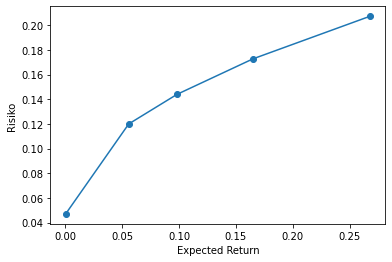

In [303]:
import matplotlib.pyplot as plt

y = df_port["Expected Return"]
x = df_port["Risiko"]

plt.plot(x,y)
plt.scatter(x,y)
plt.xlabel("Expected Return")
plt.ylabel("Risiko")
plt.show()